# Data Preparation

This file carries out the preparation of our data.

## Import Necessary Libraries

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import json

import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download('popular')

from sklearn.feature_extraction.text import CountVectorizer
import scipy

import matplotlib.pyplot as plt

## Read in the Data

In [2]:
# read in the data
df = pd.DataFrame()
for i in range(20):
    new_df = pd.read_csv('../Data/reddit_data_full_text/df40k_' + str(i) + '.csv')
    df = pd.concat([df, new_df], axis = 0)

# drop the column that used to be the index
df = df.drop(columns = ['Unnamed: 0'])

In [3]:
# print data features
print('DataFrame Shape:', df.shape)
display(df.head())

DataFrame Shape: (200000, 4)


,author,subreddit,content,summary
0,HuevoSplash,AskReddit,"Seems smarter"" is why it won't work. I've see...",The system is the problem. Going inside it wo...
1,gravedigger04325,AskReddit,Travel back to the 1980s and nuke the everlovi...,Nuke. Boom. 2 time lines.
2,adamshell,AskReddit,I'm the preacher at a small church in Virginia...,"If times are tough, would you ask for financia..."
3,allthatsalsa,AskReddit,One of my roommates moved out several months a...,Roommate left a pool table and a couch. He's n...
4,soulcaptain,AskReddit,I was stopped at a red light that also just ha...,"Got stuck on a railroad track, just barely eva..."


## Clean the Textual Data

In [5]:
# build lemmatizer and porter stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# gather stop words
stop_words = set(stopwords.words('english'))

# start collecting clean texts and vocabulary
new_texts = []; vocabulary = set()

# clean each post in the 'content' column
for content in df['content']:
    # convert to lower case for easier use
    text = content.lower()
    # remove apostrophes and quotation marks (don't -> dont)
    text = text.replace("'", '').replace('"', '').replace('/n', '')
    # keep only alphanumeric characters and spaces
    text = ''.join([char for char in text if char in 'abcdefghijklmnopqrstuvxwyz '])
    # lemmatize and stem the words
    new_words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    new_words = [stemmer.stem(word) for word in new_words if word not in stop_words]
    # gather text by combining word lists into string
    new_text = ' '.join(new_words)
    # update the vocabulary with the new words
    vocabulary.update(new_words)
    # store the new text
    new_texts.append(new_text)

## Apply `CountVectorizer`

In [8]:
# make CountVectorizer
vectorizer = CountVectorizer()

# gather the sparse matrix representation
X = vectorizer.fit_transform(new_texts)

In [10]:
# remove all words appearing only once
col_sums = np.array(np.sum(X, axis = 0))[0]
keep_cols = col_sums > 1
new_matrix = X[:, keep_cols]

# store corresponding vocabulary
word_list = vectorizer.get_feature_names_out()[keep_cols]

In [13]:
print('Sparse Matrix Shape:', new_matrix.shape, ', Vocabulary List Length:', len(word_list))

Sparse Matrix Shape: (200000, 78976) , Vocabulary List Length: 78976


## Export Sparse Matrix and Vocabulary

**This is the version with shape (200,000 , 78,976)**

In [84]:
# save the sparse matrix
scipy.sparse.save_npz('../Data/subreddit_csr.npz', new_matrix)

# save the vocabulary as JSON
with open('../Data/subreddit_vocabulary.json', 'w') as file:
    json.dump(list(word_list), file)

# save the classifications as JSON
with open('../Data/subreddit_classes.json', 'w') as file:
    json.dump(list(df['subreddit']), file)

## Dimension Reduction

In [3]:
# read in sparse representation of vocabulary
sparse_matrix = scipy.sparse.load_npz('../Data/subreddit_csr.npz')

# read in vocabulary itself
with open('../Data/subreddit_vocabulary.json', 'r') as file:
    vocabulary = json.load(file)

print('Shape of Sparse Matrix:', sparse_matrix.shape)
print('Length of Vocabulary:', len(vocabulary))

Shape of Sparse Matrix: (200000, 78976)
Length of Vocabulary: 78976


### Dimension Reduction 1: Word Count Elbow Method

In [4]:
# sort the word frequencies, keeping the vocabulary aligned
frequencies = np.array(np.sum(sparse_matrix, axis = 0))[0]
sorted_frequencies = np.sort(frequencies)[::-1]
sorted_vocabulary = [x for _, x in sorted(zip(frequencies, vocabulary))][::-1]

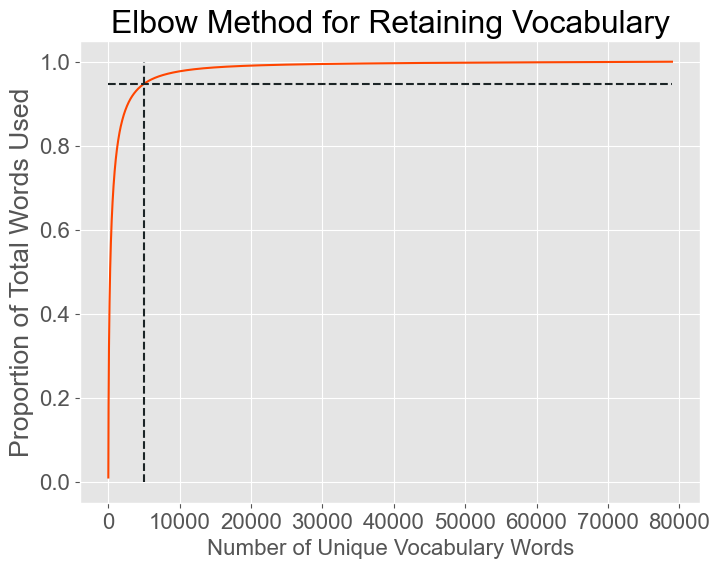

In [6]:
# keep a number of words in vocabulary
words_kept = 5000

fig, ax = plt.subplots(figsize = (8, 6))

# plot the cumulative sum of word frequencies
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 16})
plt.plot(np.cumsum(sorted_frequencies) / np.sum(sorted_frequencies), color = '#FF4500')
# plt.xlim(-200, 20200); plt.ylim(-0.05, 1.05)
plt.xlabel('Number of Unique Vocabulary Words', fontsize = 16); plt.ylabel('Proportion of Total Words Used')
plt.title('Elbow Method for Retaining Vocabulary')
plt.vlines(x = words_kept, ymin = 0, ymax = 1, color = '#1B2426', linestyles = 'dashed')
plt.hlines(y = np.cumsum(sorted_frequencies)[words_kept - 1] / np.sum(sorted_frequencies),\
            xmin = 0, xmax = 78976, color = '#1B2426', linestyles = 'dashed')
plt.savefig('../Output/DataPreparationResults/vocabulary_elbow_method.png')

In [64]:
# calculate the proportion of words used from n words kept
prop = np.cumsum(sorted_frequencies)[words_kept - 1] / np.sum(sorted_frequencies)
print('We can retain a proportion of words used of', round(prop, 4), 'with only',\
       words_kept, 'of 245050 words kept ( proportion of', round(words_kept / 245050, 5), ').')

We can retain a proportion of words used of 0.9475 with only 5000 of 245050 words kept ( proportion of 0.0204 ).


In [65]:
# keep 5,000 word frequencies and vocabulary words
kept_frequencies = sorted_frequencies[:words_kept] # sorted greatest to least
kept_vocabulary = sorted_vocabulary[:words_kept] # sorted greatest frequency to least

In [67]:
# find the indices in the sparse matrix where we want to keep our 5,000 words
keep_indices = [index for index, word in enumerate(vocabulary) if word in kept_vocabulary]
keep_words = [word for word in vocabulary if word in kept_vocabulary] # allows us to get the ordering in the sparse matrix

# extract the correct columns of the sparse matrix
kept_matrix = sparse_matrix[:, keep_indices]

print('Shape of Sparse Matrix:', kept_matrix.shape)
print('Length of Kept Vocabulary', len(keep_words))

Shape of Sparse Matrix: (200000, 5000)
Length of Kept Vocabulary 5000


We've successfully retained 5,000 columns of the sparse matrix representation (5,000 words for 200,000 posts)

## Export (Reduced) Sparse Matrix and Vocabulary

**This is the version with shape (200,000 , 5,000)**

In [69]:
# save the reduced sparse matrix
scipy.sparse.save_npz('../Data/subreddit_csr_5000.npz', kept_matrix)

# save the reduced vocabulary as JSON
with open('../Data/subreddit_vocabulary_5000.json', 'w') as file:
    json.dump(list(keep_words), file)